### Upload the CSV file for spam-ham data.
Link of dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [53]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam (1).csv


### Imports

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from joblib import dump
import os

# preprocessing and model preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


### Create preprocessing function for text

In [55]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


### Import CSV file and prepare data for further process

In [56]:
df = pd.read_csv("/content/spam.csv", encoding="latin1")
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.columns = ["label", "text"]
df["text"] = df["text"].apply(preprocess)
df["spam"] = df["label"].apply(lambda x: 1 if x == "spam" else 0)
df.drop(columns = "label", inplace=True)
df.head()

,text,spam
0,jurong point crazy available bugis n great wor...,0
1,ok lar joke wif u oni,0
2,free entry 2 wkly comp win FA Cup final tkts 2...,1
3,u dun early hor u c,0
4,nah think go usf live,0


### Check if there is imbalance in data between spam and ham
##### We can clearly see here that data available for ham is around 5x more than spam

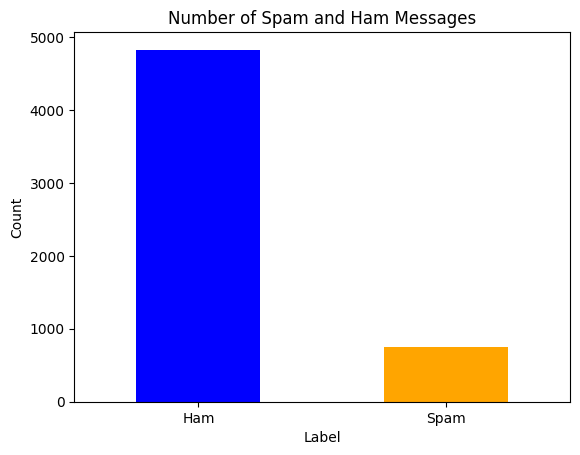

In [57]:
counts = df['spam'].value_counts()

# Plot the counts as a bar chart
counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

### Create pipelines

In [58]:
pipelines = {
    "Naive Bayes": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("nb", MultinomialNB())
    ]),
    "Logistic Regression": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("lr", LogisticRegression(class_weight='balanced'))
    ]),
    "Support Vector Machine": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("svc", SVC(class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("rfc", RandomForestClassifier(class_weight='balanced'))
    ])
}

### Apply ML
#### 1. Split data into train and test
#### 2. Fit the data to model
#### 3. Store the model for later use


In [59]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["spam"], test_size=0.2, random_state=50)

In [60]:
def store_model(model, pipeline):
    model_dir = "/content/saved_models"
    os.makedirs(model_dir, exist_ok=True)

    # Save the trained pipeline
    model_path = os.path.join(model_dir, f"{'_'.join(model.split(' '))}_model.joblib")
    dump(pipeline, model_path)
    print(f"{model} model saved to {model_path}")

In [61]:
models = []
accuracy = []
precision = []
recall = []
f1_score = []

# Iterate over each model and pipeline
for model, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    store_model(model, pipeline)

    # Calculate metrics
    models.append(model)
    accuracy.append(accuracy_score(y_test, y_pred))
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    precision.append(prec)
    recall.append(rec)
    f1_score.append(f1)


Naive Bayes model saved to /content/saved_models/Naive_Bayes_model.joblib
Logistic Regression model saved to /content/saved_models/Logistic_Regression_model.joblib
Support Vector Machine model saved to /content/saved_models/Support_Vector_Machine_model.joblib
Random Forest model saved to /content/saved_models/Random_Forest_model.joblib


### Compare each model by their classification report

In [62]:
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Set 'Model' as index
metrics_df.set_index('Model', inplace=True)

# Transpose the DataFrame
metrics_df = metrics_df.T
metrics_df

Model,Naive Bayes,Logistic Regression,Support Vector Machine,Random Forest
Accuracy,0.956951,0.976682,0.978475,0.973991
Precision,1.000000,0.929936,0.992806,0.992537
Recall,0.701863,0.906832,0.857143,0.826087
F1 Score,0.824818,0.918239,0.920000,0.901695


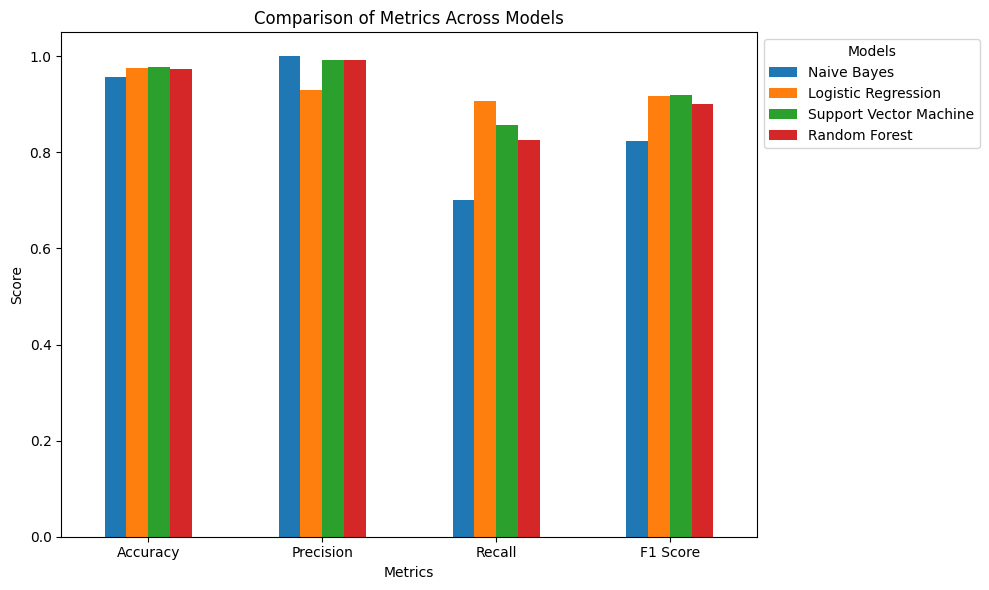

In [63]:
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Metrics Across Models')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Models', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()